# Initialization

Load data

In [1]:
import pickle


with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

fingerprints_train_raw = splits['fingerprints_train']
fingerprints_val_raw = splits['fingerprints_val']
targets_train = splits['targets_train']
targets_val = splits['targets_val']

Scale the fingerprints and format the data

In [2]:
from sklearn.preprocessing import StandardScaler
import torch


# Scale the fingerprints
scaler = StandardScaler()
fingerprints_train = scaler.fit_transform(fingerprints_train_raw)
fingerprints_val = scaler.transform(fingerprints_val_raw)

# Convert everything to Tensors for GPyTorch
fingerprints_train = torch.Tensor(fingerprints_train).contiguous()
fingerprints_val = torch.Tensor(fingerprints_val)
targets_train = torch.Tensor(targets_train.reshape(-1))
targets_val = torch.Tensor(targets_val.reshape(-1))

Define an exact GP

In [3]:
import gpytorch


# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Train

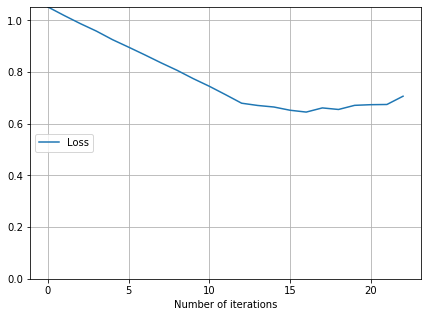

CPU times: user 23min 42s, sys: 4min 42s, total: 28min 25s
Wall time: 14min 57s


In [4]:
%matplotlib inline
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import clear_output


# Initialize the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(fingerprints_train, targets_train, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Function to make dynamic learning curve
def live_plot(data_dict, figsize=(7, 5), title=''):
    ''' Credit to Ziofil on StackOverflow '''
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Number of iterations')
    plt.legend(loc='center left')  # the plot evolves to the right
    ax = plt.gca()
    ax.set_ylim(0, max(max(data) for data in data_dict.values()))
    plt.show()

def train(training_iterations=25):
    # Train the model
    learning_curve_data = defaultdict(list)
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(fingerprints_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, targets_train)
        loss.backward()
        # Update the learning curve
        learning_curve_data['Loss'].append(loss.item())
        live_plot(learning_curve_data)
        optimizer.step()

%time train(23)

# Assess performance

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make the predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    %time preds = model(fingerprints_val)

CPU times: user 2min 12s, sys: 6.23 s, total: 2min 18s
Wall time: 1min 12s


MAE = 0.23 eV
RMSE = 0.42 eV
R^2 = 0.72


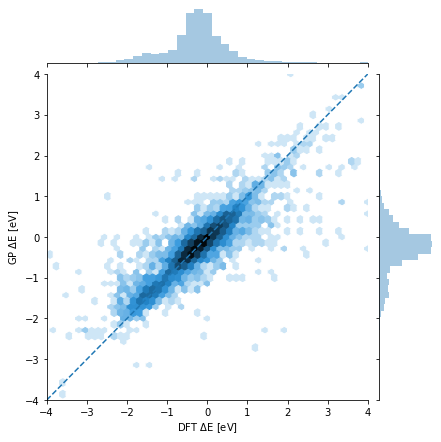

In [6]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Parse the predictions
targets_pred = preds.mean
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val, targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims*2)
_ = grid.ax_joint.set_xlim(lims)
_ = grid.ax_joint.set_ylim(lims)
_ = grid.ax_joint.plot(lims, lims, '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('GP $\Delta$E [eV]')

In [7]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


residuals = (targets_pred - targets_val).detach().numpy()
standard_errors = preds.stddev.detach().numpy()

def calculate_density(percentile):
    num_within_quantile = 0
    for se, resid in zip(standard_errors, residuals):
        norm = stats.norm(loc=0, scale=se)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

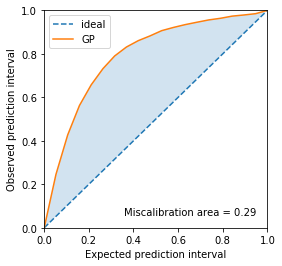

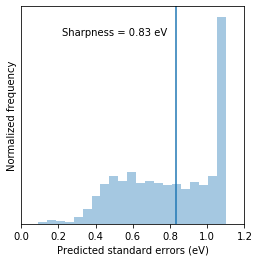

In [52]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label='GP')
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')


# Plot sharpness curve
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(standard_errors, kde=False, norm_hist=True)
ax_sharp.set_xlim([0, 1.2])
ax_sharp.set_xlabel('Predicted standard errors (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])


# Calculate and report sharpness
sharpness = np.sqrt(np.mean(standard_errors**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
_ = plt.text(x=sharpness-0.05, y=5,
             s='Sharpness = %.2f eV' % sharpness,
             verticalalignment='top',
             horizontalalignment='right')